In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../creme/')
import creme
import utils
import custom_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shuffle

2024-06-10 14:39:13.224762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Enformer and example sequences

In [2]:
track_index = [5111]
model = custom_model.Enformer(track_index=track_index)
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_line_info = {i: [t, utils.clean_cell_name(target_df.iloc[t]['description'])] for i, t in
              enumerate(track_index)}

2024-06-10 14:39:17.638837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 14:39:18.081015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78954 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [81]:
fasta_path = f'../data/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

gene = 'KIT_chr4_54657941_+'

gene_name, chrom, start, strand = gene.split('_')
wt_seq = seq_parser.extract_seq_centered(chrom, int(start), strand, model.seq_length)


In [82]:
# TSS bin indeces
bins = [447, 448]

In [83]:
wt = model.predict(wt_seq)[0,:,0]


<Axes: >

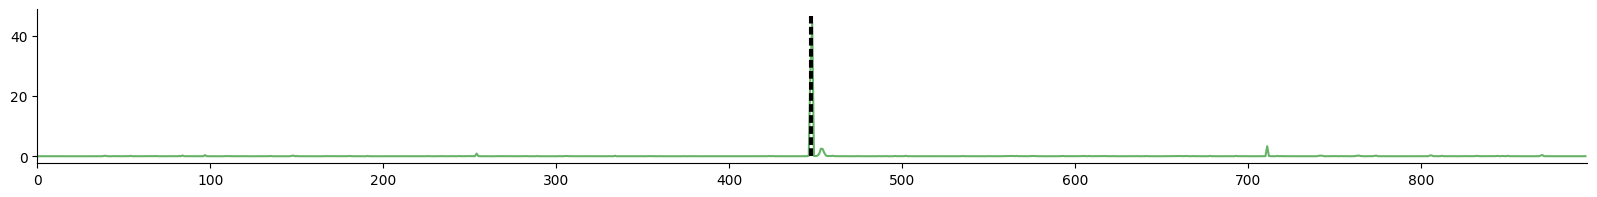

In [84]:
utils.plot_track([wt], color='green', zoom=[0, 896], marks=bins)


# Multiplicity test
In this example we will test the saturation effect of (5Kb) CRE tile in the context of an enhancing context sequence of ZNF93 gene. 

To run the test we need:
- a loaded model
- onehot encoded sequence (WT) of the sequence
- list of start and end coordiantes of the TSS tile
- list of start and end coordiantes to place the CRE in for the control case (we will use the original position)
- onehot encoded sequence of the CRE tile
- list of lists of start and end coordiantes to embed/test CRE effect
- num_shuffle - number of shuffled
- number of iterations to run or copies to insert
- np.argmax or np.argmin to optimize for enhancers or silencers

In [85]:

perturb_window = 5000
N_shuffles = 10
num_copies = 3
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, perturb_window)
enhancing_cre = [105804, 110804]
print(f'Enhancing tile at position {enhancing_cre[0]} - {enhancing_cre[1]}')
print(f'TSS tile at center position {tss_tile[0]} - {tss_tile[1]}')

Enhancing tile at position 105804 - 110804
TSS tile at center position 95804 - 100804


## Multiplicity effect of an enhancing tile of ZNF93 gene TSS

In [86]:
model.bin_index = [447, 448]
cre_seq = wt_seq[enhancing_cre[0]:enhancing_cre[1]].copy()
result_summary = creme.multiplicity_test(model, wt_seq, tss_tile, enhancing_cre, cre_seq,
                                         cre_tiles, N_shuffles, num_copies, np.argmax)

100%|████████████████████████████████████████████████████████████████████████████| 3/3 [08:41<00:00, 173.86s/it]


In [87]:
result_summary.keys()

dict_keys(['only_tss_pred', 'tss_and_cre_pred', 'best_tss_signal', 'selected_tile_order', 'all_mutants'])

In [88]:
print(f"TSS signal with CRE copies at the optimal positions: {result_summary['best_tss_signal']}")
print(f"TSS signal in shuffled context: {result_summary['only_tss_pred']}")
print(f"TSS signal in shuffled context + CRE at original position: {result_summary['tss_and_cre_pred']}")
print(f"Tile order: {result_summary['selected_tile_order']}")

TSS signal with CRE copies at the optimal positions: [3.631044265255332, 19.56945643424988, 32.70301297903061]
TSS signal in shuffled context: 0.12562379240989685
TSS signal in shuffled context + CRE at original position: 3.631044387817383
Tile order: [[105804, 110804], [100804, 105804], [120804, 125804]]


Now, let's recreate the final sequence at each iteration and plot the entire track (instead of only looking at the TSS signal).

In [92]:
model.bin_index = None
background_seqs_wth_TSS = shuffle.dinuc_shuffle(wt_seq, 10)
background_seqs_wth_TSS[:, tss_tile[0]:tss_tile[1], :] = wt_seq[tss_tile[0]:tss_tile[1], :]
just_tss_pred = model.predict(background_seqs_wth_TSS)[0,:,0]

In [90]:
CREs_and_TSS = background_seqs_wth_TSS.copy()
preds_per_iter = []
for tile_position in result_summary['selected_tile_order']:
    print(tile_position)
    CREs_and_TSS[:, tile_position[0]:tile_position[1],:] = cre_seq.copy()
    preds_per_iter.append(np.array(model.predict(CREs_and_TSS)[:,:,0]).mean(axis=0))
    

[105804, 110804]
[100804, 105804]
[120804, 125804]


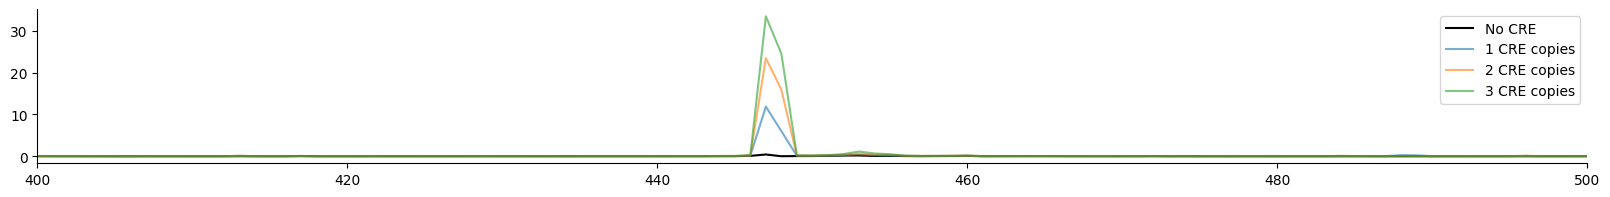

In [98]:
ax=utils.plot_track([just_tss_pred], label='No CRE', color='k', alpha=1)
for i, p in enumerate(preds_per_iter):
    utils.plot_track([p], zoom=[400, 500], ax=ax, label=f"{i+1} CRE copies")
plt.legend()